In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib.patches as mpatches

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [3]:
def load_csv(path):
    """
    vraća matricu u formatu:
      - redovi = n-grami (uzorci za klasterovanje)
      - kolone = virus.protein (frekvencije)
    + dodaje pomoćne kolone za bojenje:
      - 'dominant_virus': virus sa najvećom vrednošću po n-gramu
      - 'dominant_protein': protein sa najvećom vrednošću po n-gramu
    """
    # Učitavanje kao string radi stabilnosti
    df_raw = pd.read_csv(path, dtype=str, low_memory=False)

    #   - kolona 'ngram'
    #   - prva vrsta (row 0) sadrži tip proteina za svaku sledeću kolonu
    #   - od 2. vrste naniže su frekvencije (counts)
    assert "ngram" in df_raw.columns, "CSV mora imati kolonu 'ngram'"

    # Imena kolona (virusi.proteini)
    data_cols = df_raw.columns[1:]
    # Protein po koloni je u prvom redu (row 0)
    protein_types_by_col = df_raw.iloc[0, 1:].astype(str)

    # Numerički deo: od 2. vrste naniže
    data = df_raw.iloc[1:, 1:].apply(pd.to_numeric, errors="coerce").fillna(0)
    ngrams = df_raw["ngram"].iloc[1:].values
    data.index = ngrams
    data.columns = data_cols

    # Ekstrakcija virus_type iz naziva kolone (pre prve tačke), npr "SARS2.spike"
    virus_by_col = pd.Series(
        [c.split(".")[0] if "." in c else c for c in data_cols],
        index=data_cols,
        dtype=str
    )

    # Dominantne etikete po n-gramu (za bojenje)
    # kolona sa najvećom vrednošću daje dominant virus/protein
    argmax_idx = data.values.argmax(axis=1)
    argmax_cols = data.columns[argmax_idx]

    dominant_virus = [virus_by_col[c] for c in argmax_cols]
    dominant_protein = [protein_types_by_col[c] if c in protein_types_by_col.index else "NA"
                        for c in argmax_cols]

    data = data.copy()
    data["dominant_virus"] = dominant_virus
    data["dominant_protein"] = dominant_protein

    return data  # redovi = n-grami, kolone = virus.protein + 2 pomoćne


# KMeans

In [3]:
def kmeans_clustering(datasets, label_column="dominant_virus", cluster_range=range(2, 11)):
    """
    Runs KMeans clustering on AMINO/NUCL n-gram datasets.
    Klasteruje PO N-GRAMIMA (redovi = n-grami).
    Bojenje u scatteru koristi:
      - label_column='dominant_virus' ili 'dominant_protein'
    """
    pretty_titles = {
        "dominant_virus": "Dominantni virus",
        "dominant_protein": "Dominantni protein"
    }

    results = {name: {"clusters": [], "silhouette": [], "calinski": [], "davies": []}
               for name in datasets}

    fig, axes = plt.subplots(len(datasets), 4, figsize=(22, 5 * len(datasets)))
    if len(datasets) == 1:
        axes = [axes]

    for i, (name, df) in enumerate(datasets.items()):
        # --- priprema matrice ---
        numeric_df = df.select_dtypes(include=[np.number])
        X = numeric_df.values

        # --- oznake za bojenje (po redu = n-gram) ---
        if label_column in df.columns:
            labels_for_color = df[label_column].astype(str).values
        else:
            # fallback: sve jedne boje
            labels_for_color = np.array(["all"] * len(df))

        # Skaliranje
        scaler = StandardScaler()
        Xs = scaler.fit_transform(X)

        # Evaluacija metrika
        for k in cluster_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(Xs)
            y = kmeans.labels_
            results[name]["clusters"].append(k)
            results[name]["silhouette"].append(silhouette_score(Xs, y))
            results[name]["calinski"].append(calinski_harabasz_score(Xs, y))
            results[name]["davies"].append(davies_bouldin_score(Xs, y))

        # --- Plot metrika ---
        metrics = ["silhouette", "calinski", "davies"]
        for j, metric in enumerate(metrics):
            ax = axes[i][j]
            ax.plot(results[name]["clusters"], results[name][metric], marker="o")
            ax.set_title(f"{name} - {metric}")
            ax.set_xlabel("Broj klastera")
            ax.set_ylabel(metric.capitalize())

        # --- Scatter (PCA 2D) za najbolji k po silhouette ---
        best_k = results[name]["clusters"][np.argmax(results[name]["silhouette"])]
        kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto").fit(Xs)
        y = kmeans.labels_

        from sklearn.decomposition import PCA
        pca = PCA(n_components=2, random_state=42)
        XY = pca.fit_transform(Xs)

        ax_scatter = axes[i][3]
        ax_scatter.set_title(
            f"{name} - KMeans (k={best_k}) colored by {pretty_titles.get(label_column, label_column)}"
        )

        # mapiranje boja po vrednostima label_column
        uniq = sorted(pd.unique(labels_for_color))
        lab2int = {lab: idx for idx, lab in enumerate(uniq)}
        color_vals = np.array([lab2int[v] for v in labels_for_color])

        sc = ax_scatter.scatter(XY[:, 0], XY[:, 1], c=color_vals, cmap="tab20", s=40)

        # legende
        ncols = 1
        if len(uniq) > 10: ncols = 2
        if len(uniq) > 20: ncols = 3

        ax_scatter.legend(
            handles=sc.legend_elements()[0],
            labels=uniq,
            title=pretty_titles.get(label_column, label_column),
            bbox_to_anchor=(1.05, 1), loc="upper left",
            borderaxespad=0., ncol=ncols
        )

    plt.tight_layout()
    plt.show()

    return results

In [5]:
df3 = load_csv("../csv_data/3gram_matrix_amino_acid_combined.csv")
df4 = load_csv("../csv_data/4gram_matrix_amino_acid_combined.csv")
df5 = load_csv("../csv_data/5gram_matrix_amino_acid_combined.csv")
datasets = {"3-gram": df3, "4-gram": df4, "5-gram": df5}

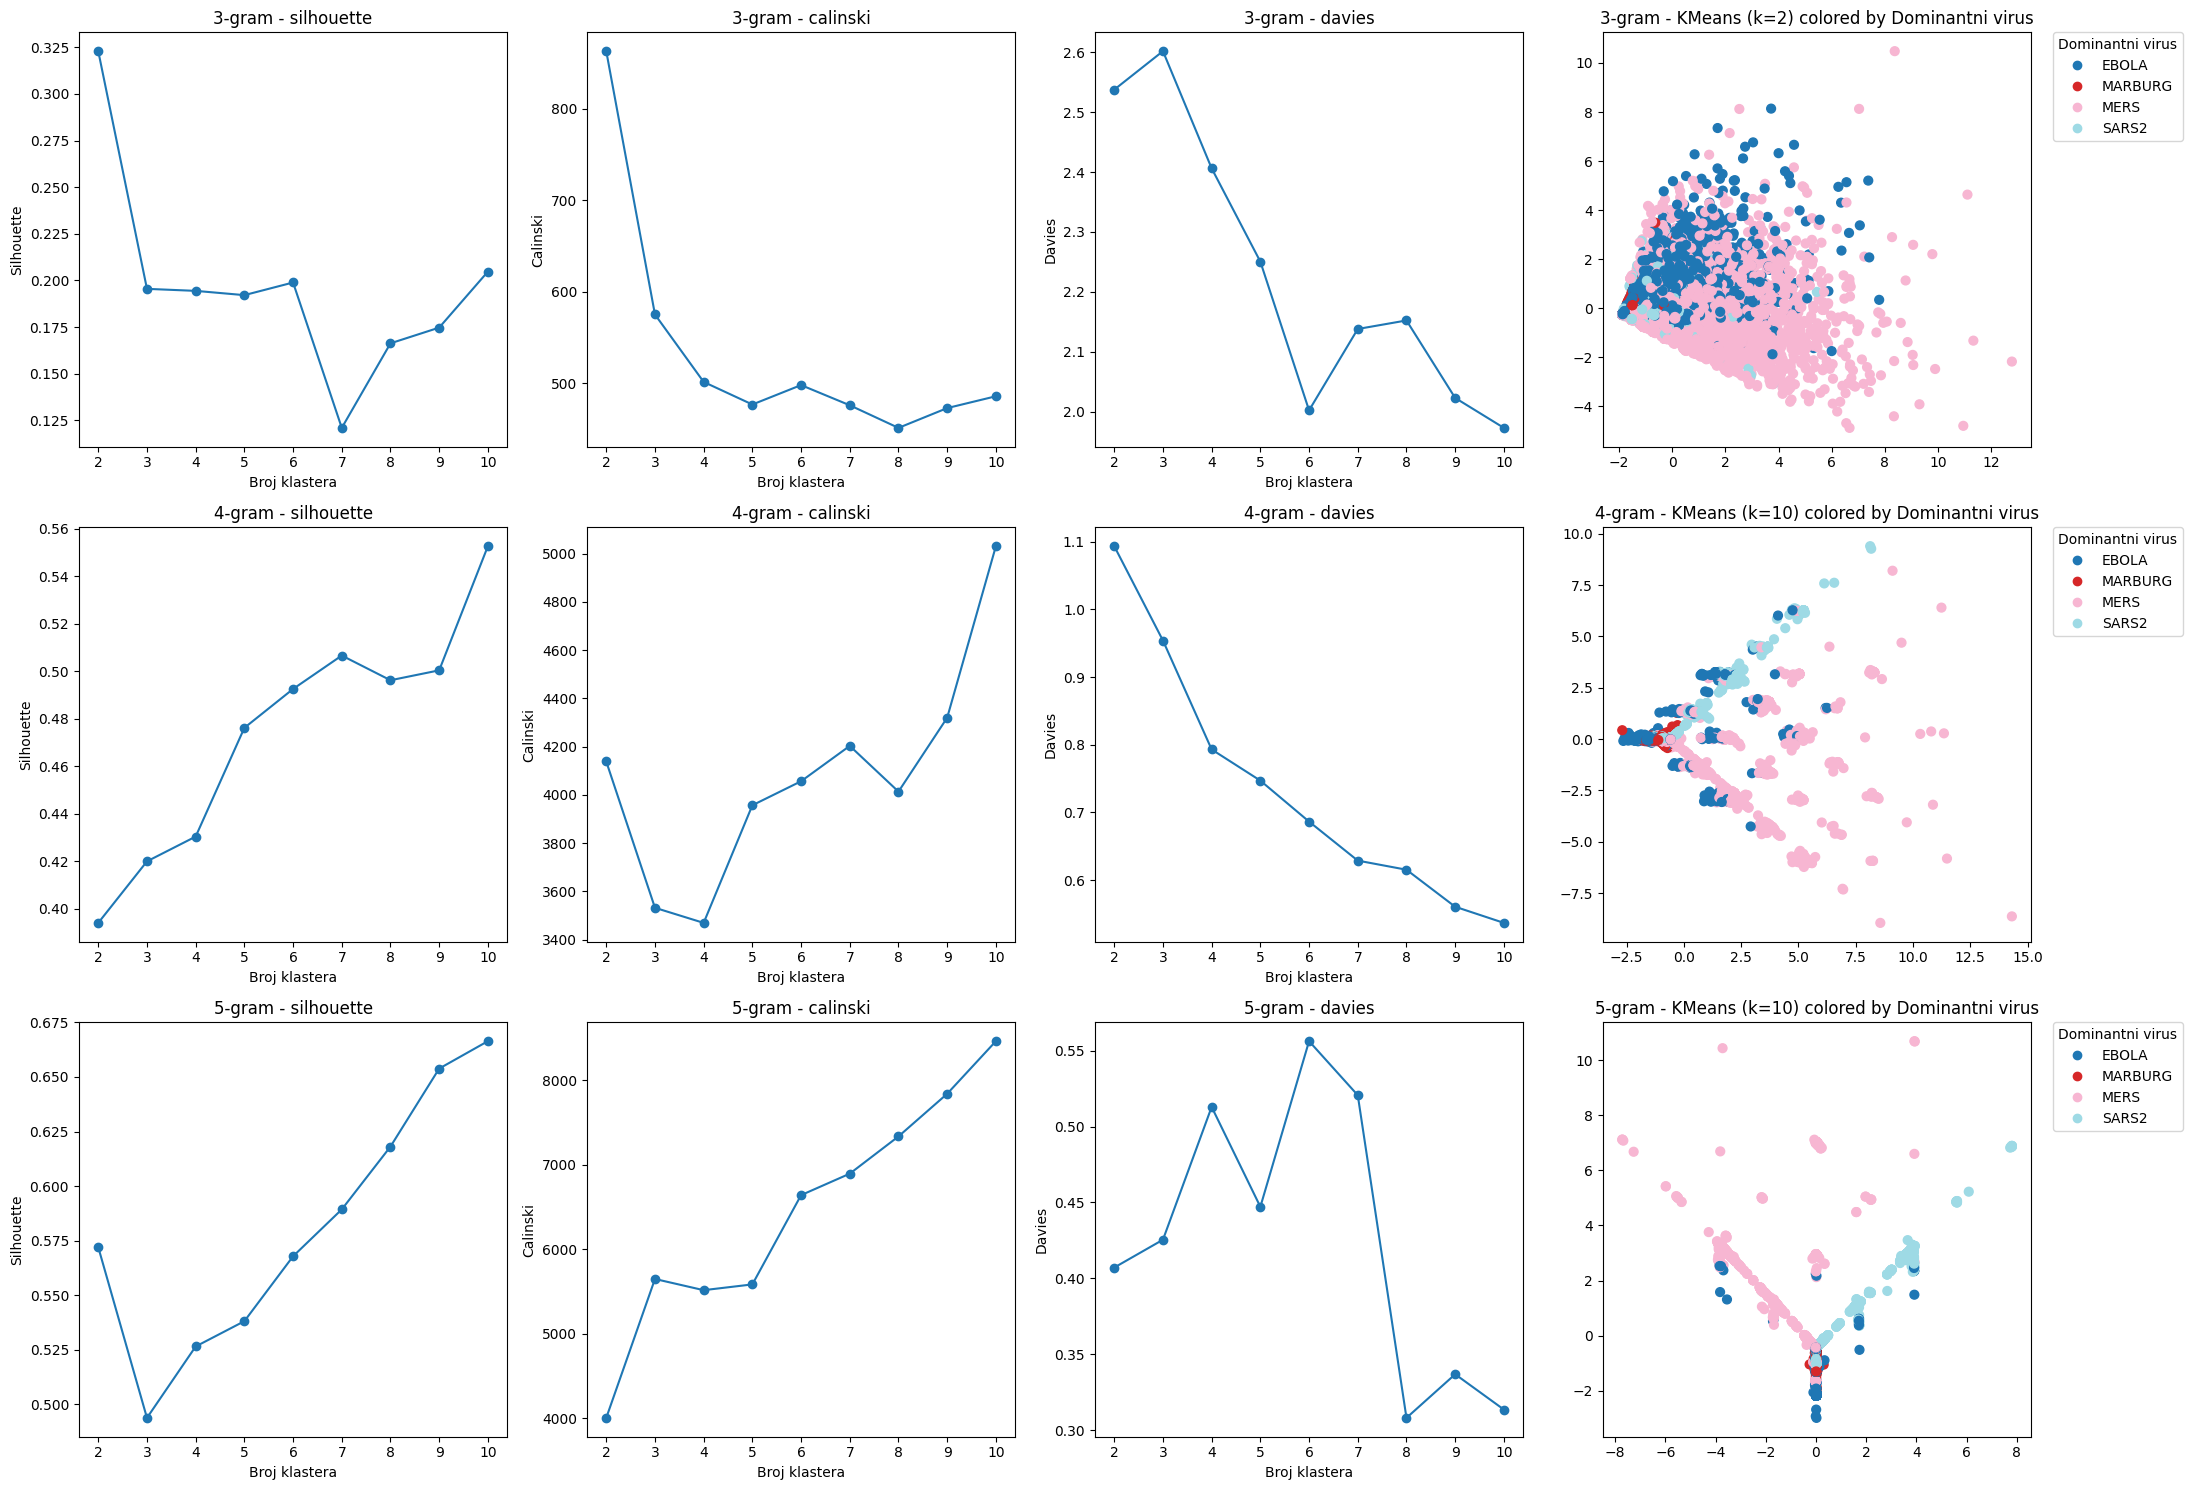

{'3-gram': {'clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'silhouette': [np.float64(0.3228802055323476),
   np.float64(0.19548862666285244),
   np.float64(0.19440658622770599),
   np.float64(0.19211718150175508),
   np.float64(0.19889199134717006),
   np.float64(0.1209677595124912),
   np.float64(0.16629478541514645),
   np.float64(0.17471337985089075),
   np.float64(0.20473182673788456)],
  'calinski': [np.float64(863.0900843017791),
   np.float64(575.1880967895394),
   np.float64(501.45349340280643),
   np.float64(476.7612933271254),
   np.float64(497.9931602221958),
   np.float64(475.9326917748961),
   np.float64(451.20782124107683),
   np.float64(472.8503923550011),
   np.float64(485.78285699341404)],
  'davies': [np.float64(2.5377841020444665),
   np.float64(2.6020860628819245),
   np.float64(2.4063198914274424),
   np.float64(2.250403623779602),
   np.float64(2.0019894152094424),
   np.float64(2.1379279320518116),
   np.float64(2.1521863991250716),
   np.float64(2.0227237798184503)

In [6]:
kmeans_clustering(datasets, label_column="dominant_virus", cluster_range=range(2, 11))

/tmp/ipython-input-1798961377.py:80: UserWarning: Mismatched number of handles and labels: len(handles) = 8 len(labels) = 20
  ax_scatter.legend(
/tmp/ipython-input-1798961377.py:80: UserWarning: Mismatched number of handles and labels: len(handles) = 8 len(labels) = 20
  ax_scatter.legend(
/tmp/ipython-input-1798961377.py:80: UserWarning: Mismatched number of handles and labels: len(handles) = 8 len(labels) = 20
  ax_scatter.legend(


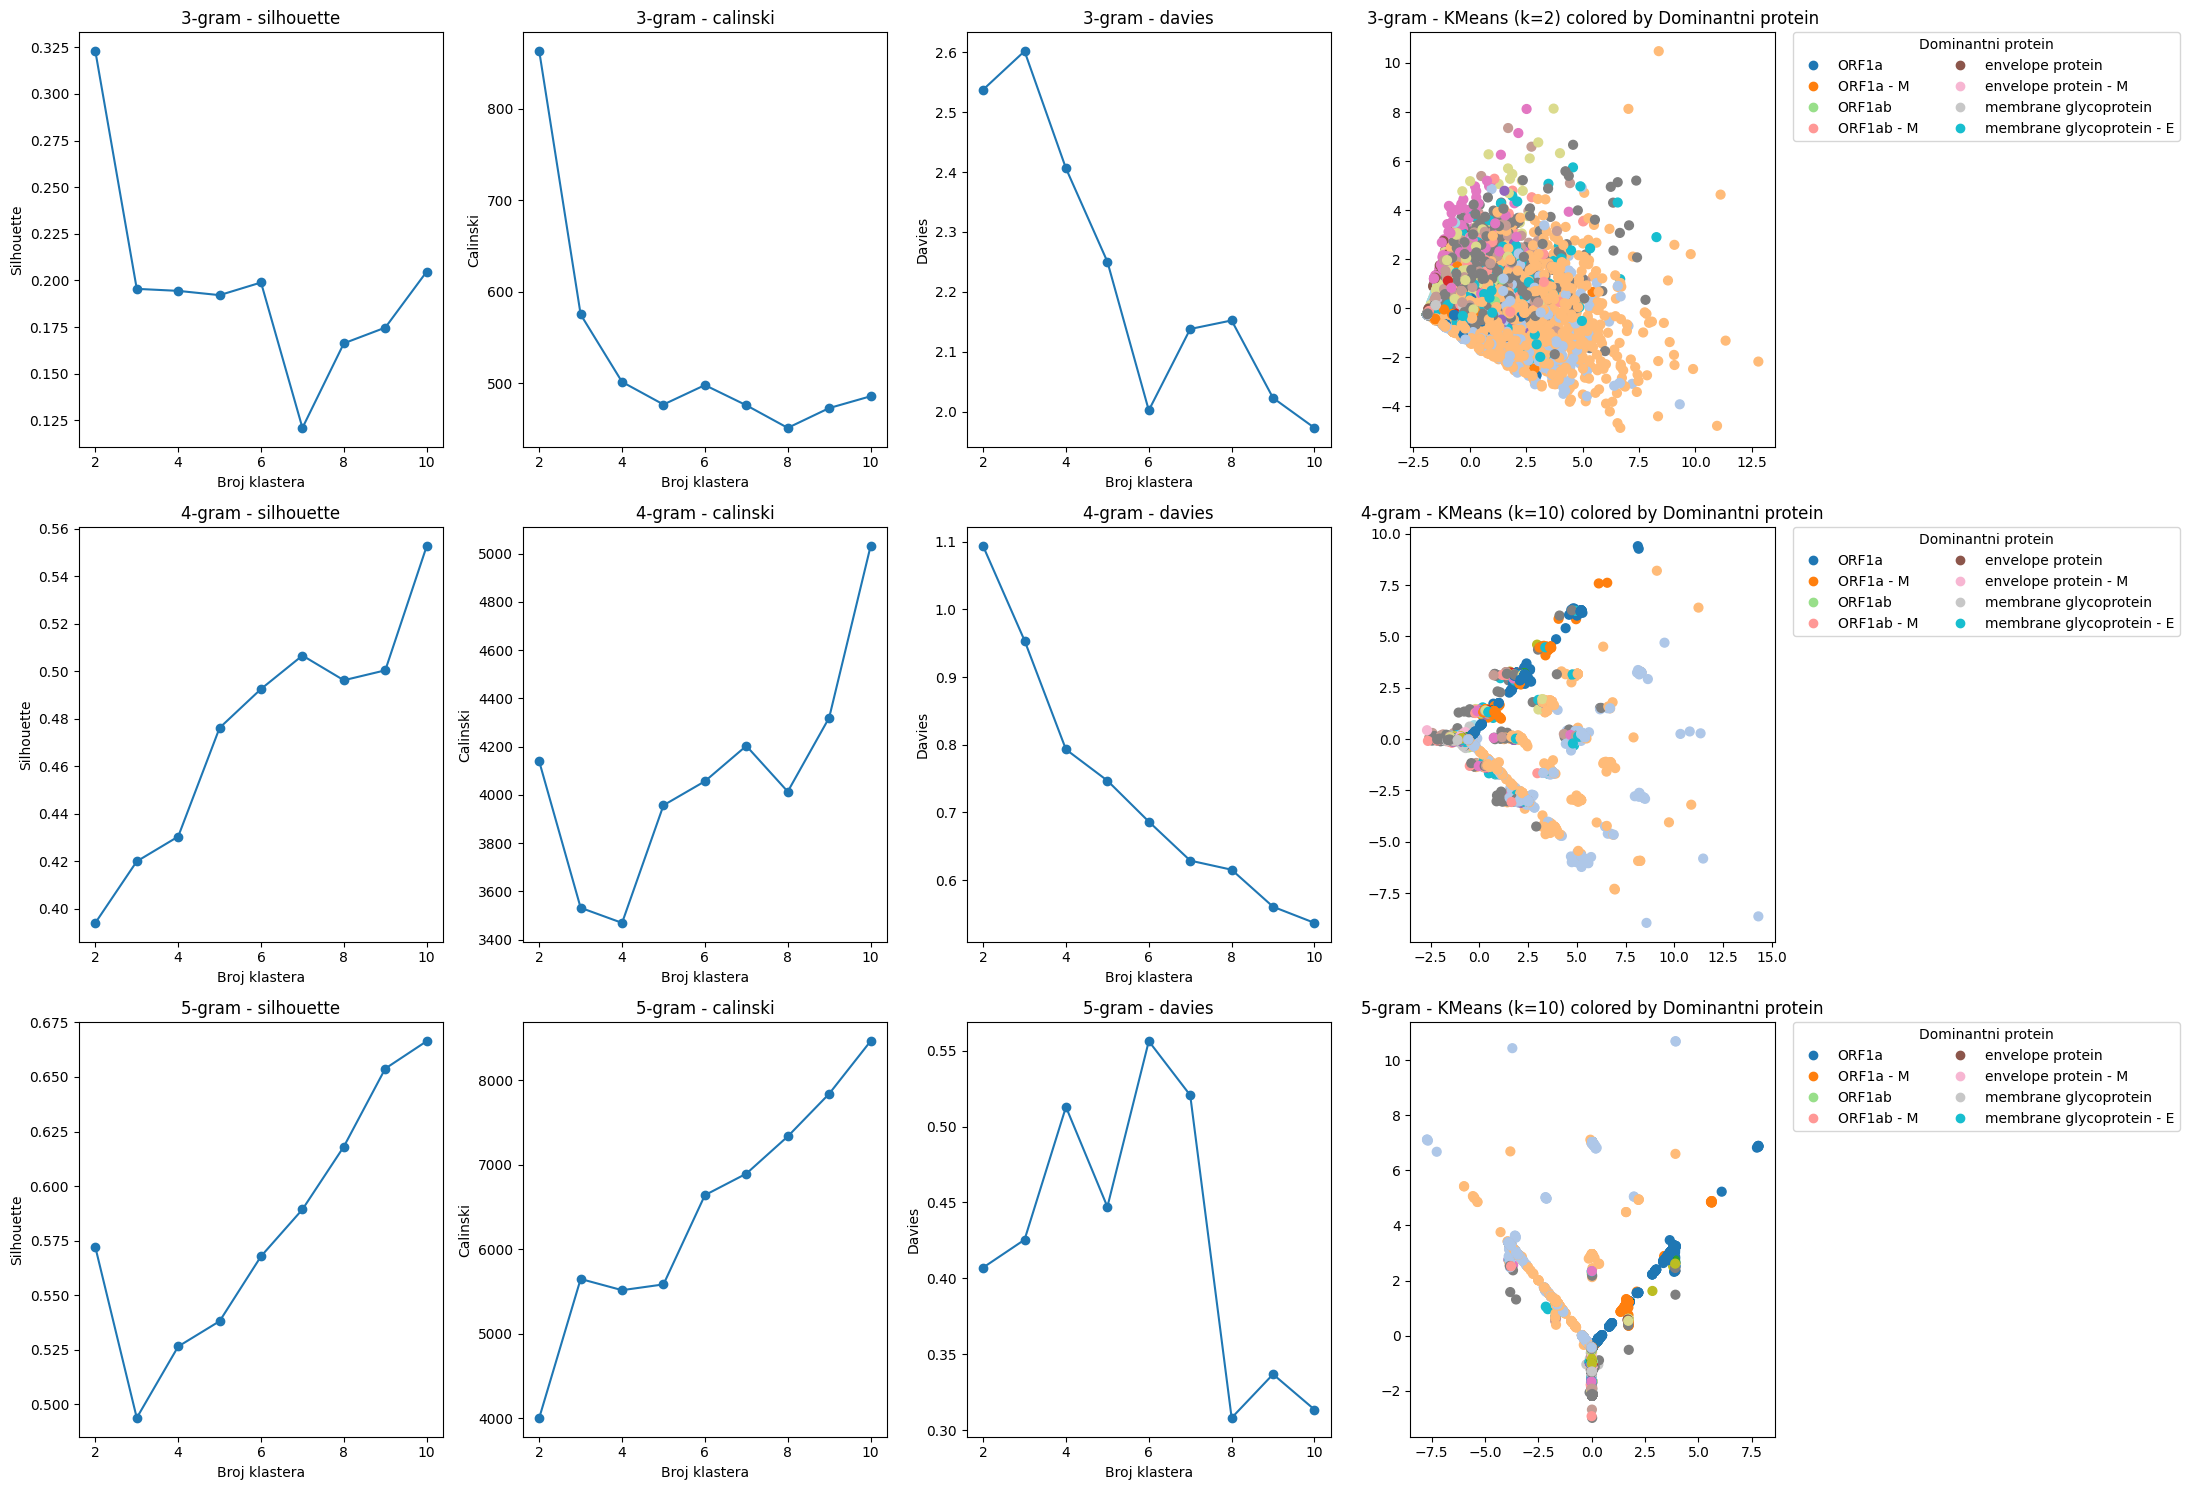

{'3-gram': {'clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'silhouette': [np.float64(0.3228802055323476),
   np.float64(0.19548862666285244),
   np.float64(0.19440658622770599),
   np.float64(0.19211718150175508),
   np.float64(0.19889199134717006),
   np.float64(0.1209677595124912),
   np.float64(0.16629478541514645),
   np.float64(0.17471337985089075),
   np.float64(0.20473182673788456)],
  'calinski': [np.float64(863.0900843017791),
   np.float64(575.1880967895394),
   np.float64(501.45349340280643),
   np.float64(476.7612933271254),
   np.float64(497.9931602221958),
   np.float64(475.9326917748961),
   np.float64(451.20782124107683),
   np.float64(472.8503923550011),
   np.float64(485.78285699341404)],
  'davies': [np.float64(2.5377841020444665),
   np.float64(2.6020860628819245),
   np.float64(2.4063198914274424),
   np.float64(2.250403623779602),
   np.float64(2.0019894152094424),
   np.float64(2.1379279320518116),
   np.float64(2.1521863991250716),
   np.float64(2.0227237798184503)

In [7]:
kmeans_clustering(datasets, label_column="dominant_protein", cluster_range=range(2, 11))

In [8]:
def visualize_clusters_only(datasets, label_key="dominant_virus", k=2):
    """
    Vizuelizacija KMeans klastera u 2D (PCA), obojenih po dominant_virus/dominant_protein.
    """
    n_plots = len(datasets)
    fig, axs = plt.subplots(1, n_plots, figsize=(7 * n_plots, 6))
    if n_plots == 1:
        axs = [axs]

    for ax, (name, df) in zip(axs, datasets.items()):
        numeric_df = df.select_dtypes(include=[np.number])
        X = numeric_df.values

        scaler = StandardScaler()
        Xs = scaler.fit_transform(X)

        pca = PCA(n_components=2, random_state=42)
        XY = pca.fit_transform(Xs)

        km = KMeans(n_clusters=k, random_state=42, n_init="auto")
        _ = km.fit_predict(Xs)
        centers_2d = pca.transform(km.cluster_centers_)

        # bojenje po label_key (dominant_virus/protein)
        if label_key in df.columns:
            row_labels = df[label_key].astype(str).values
        else:
            row_labels = np.array(["all"] * len(df))

        uniq = sorted(pd.unique(row_labels))
        lab2int = {lab: idx for idx, lab in enumerate(uniq)}
        color_vals = np.array([lab2int[v] for v in row_labels])

        sc = ax.scatter(XY[:, 0], XY[:, 1], c=color_vals, cmap="tab20",
                        s=80, edgecolor="k")

        ax.scatter(centers_2d[:, 0], centers_2d[:, 1],
                   marker="x", c="black", s=150, linewidths=3, label="Cluster centroid")

        ax.set_title(f"{name} – klasteri i '{label_key}'", fontsize=14)
        ax.set_xlabel("PCA 1", fontsize=12)
        ax.set_ylabel("PCA 2", fontsize=12)
        ax.set_aspect("equal")

        ncols = 1
        if len(uniq) > 10: ncols = 2
        if len(uniq) > 20: ncols = 3

        ax.legend(handles=sc.legend_elements()[0],
                  labels=uniq,
                  title=label_key,
                  bbox_to_anchor=(1.05, 1), loc="upper left",
                  borderaxespad=0., ncol=ncols)

    plt.tight_layout()
    plt.show()

In [9]:
def draw_legend_for_labels(datasets, label_key="dominant_virus"):
    all_labels = pd.concat([
        d[label_key].astype(str).dropna()
        for d in datasets.values() if label_key in d.columns
    ])
    unique_labels = pd.Series(all_labels.unique())
    num_labels = len(unique_labels)

    cmap = colormaps.get_cmap("tab20").resampled(max(num_labels, 1))
    colors = cmap(np.arange(num_labels))

    ncol = 4
    n_rows = int(np.ceil(num_labels / ncol))
    fig_height = 0.6 + n_rows * 0.3

    fig, ax = plt.subplots(figsize=(12, fig_height))
    ax.axis('off')

    handles = [mpatches.Patch(color=colors[i], label=unique_labels[i]) for i in range(num_labels)]
    ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.0),
              fontsize=10, ncol=ncol, frameon=False)

    plt.subplots_adjust(top=1, bottom=0, left=0.05, right=0.95)
    plt.show()

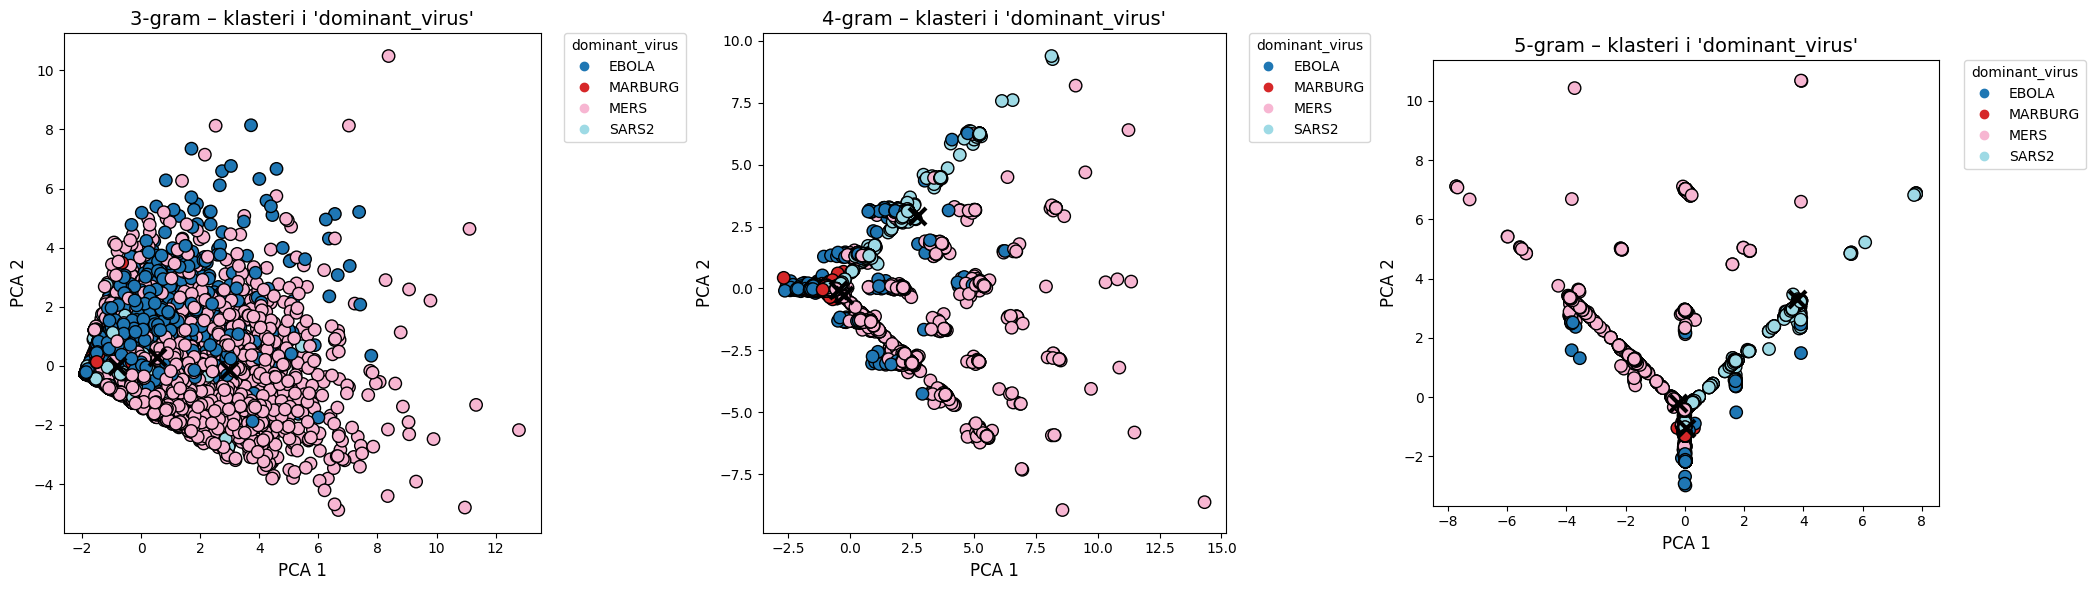

In [10]:
visualize_clusters_only(datasets, label_key="dominant_virus", k=3)

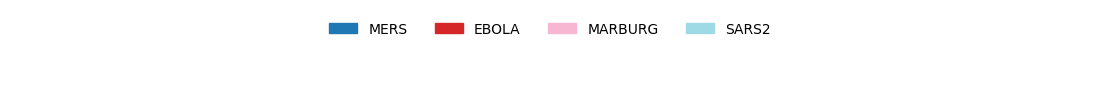

In [11]:
draw_legend_for_labels(datasets, label_key="dominant_virus")

/tmp/ipython-input-1852059410.py:49: UserWarning: Mismatched number of handles and labels: len(handles) = 8 len(labels) = 20
  ax.legend(handles=sc.legend_elements()[0],
/tmp/ipython-input-1852059410.py:49: UserWarning: Mismatched number of handles and labels: len(handles) = 8 len(labels) = 20
  ax.legend(handles=sc.legend_elements()[0],
/tmp/ipython-input-1852059410.py:49: UserWarning: Mismatched number of handles and labels: len(handles) = 8 len(labels) = 20
  ax.legend(handles=sc.legend_elements()[0],


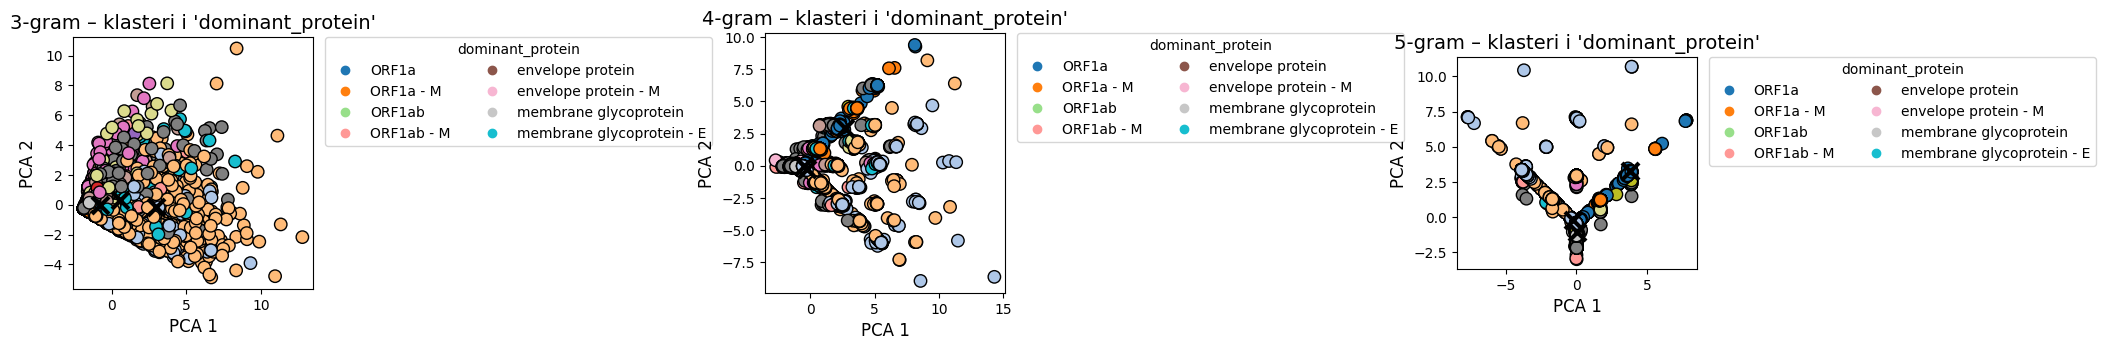

In [12]:
visualize_clusters_only(datasets, label_key="dominant_protein", k=3)

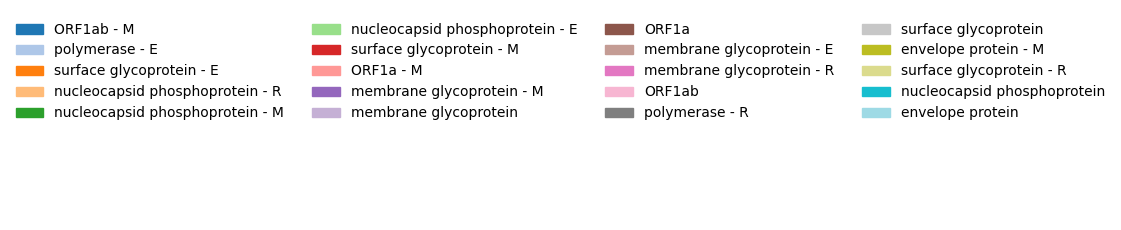

In [13]:
draw_legend_for_labels(datasets, label_key="dominant_protein")

In [14]:
def _3d_views(datasets):
    fig, axes = plt.subplots(nrows=len(datasets), ncols=5, subplot_kw={"projection": "3d"}, figsize=(20, 4*len(datasets)))

    viewpoints = [
        (20, 30),
        (90, 0),
        (0, 0),
        (0, 90),
        (45, 45)
    ]

    for i, (label, data) in enumerate(datasets.items()):
        numeric_data = data.select_dtypes(include=[np.number])
        pca = PCA(n_components=3, random_state=42)
        pcs = pca.fit_transform(numeric_data)
        evr = pca.explained_variance_ratio_

        for j, (elev, azim) in enumerate(viewpoints):
            ax = axes[i, j] if len(datasets) > 1 else axes[j]
            ax.scatter(pcs[:,0], pcs[:,1], pcs[:,2],
                       c='lightblue', edgecolors='darkblue', linewidth=0.8, alpha=0.8, s=50)
            ax.view_init(elev=elev, azim=azim)
            ax.set_title(f'{label} - View {j} (Elev: {elev}, Azim: {azim})')
            ax.set_xlabel(f'PC1 ({evr[0]*100:.1f}%)')
            ax.set_ylabel(f'PC2 ({evr[1]*100:.1f}%)')
            ax.set_zlabel(f'PC3 ({evr[2]*100:.1f}%)')

    plt.tight_layout()
    plt.show()

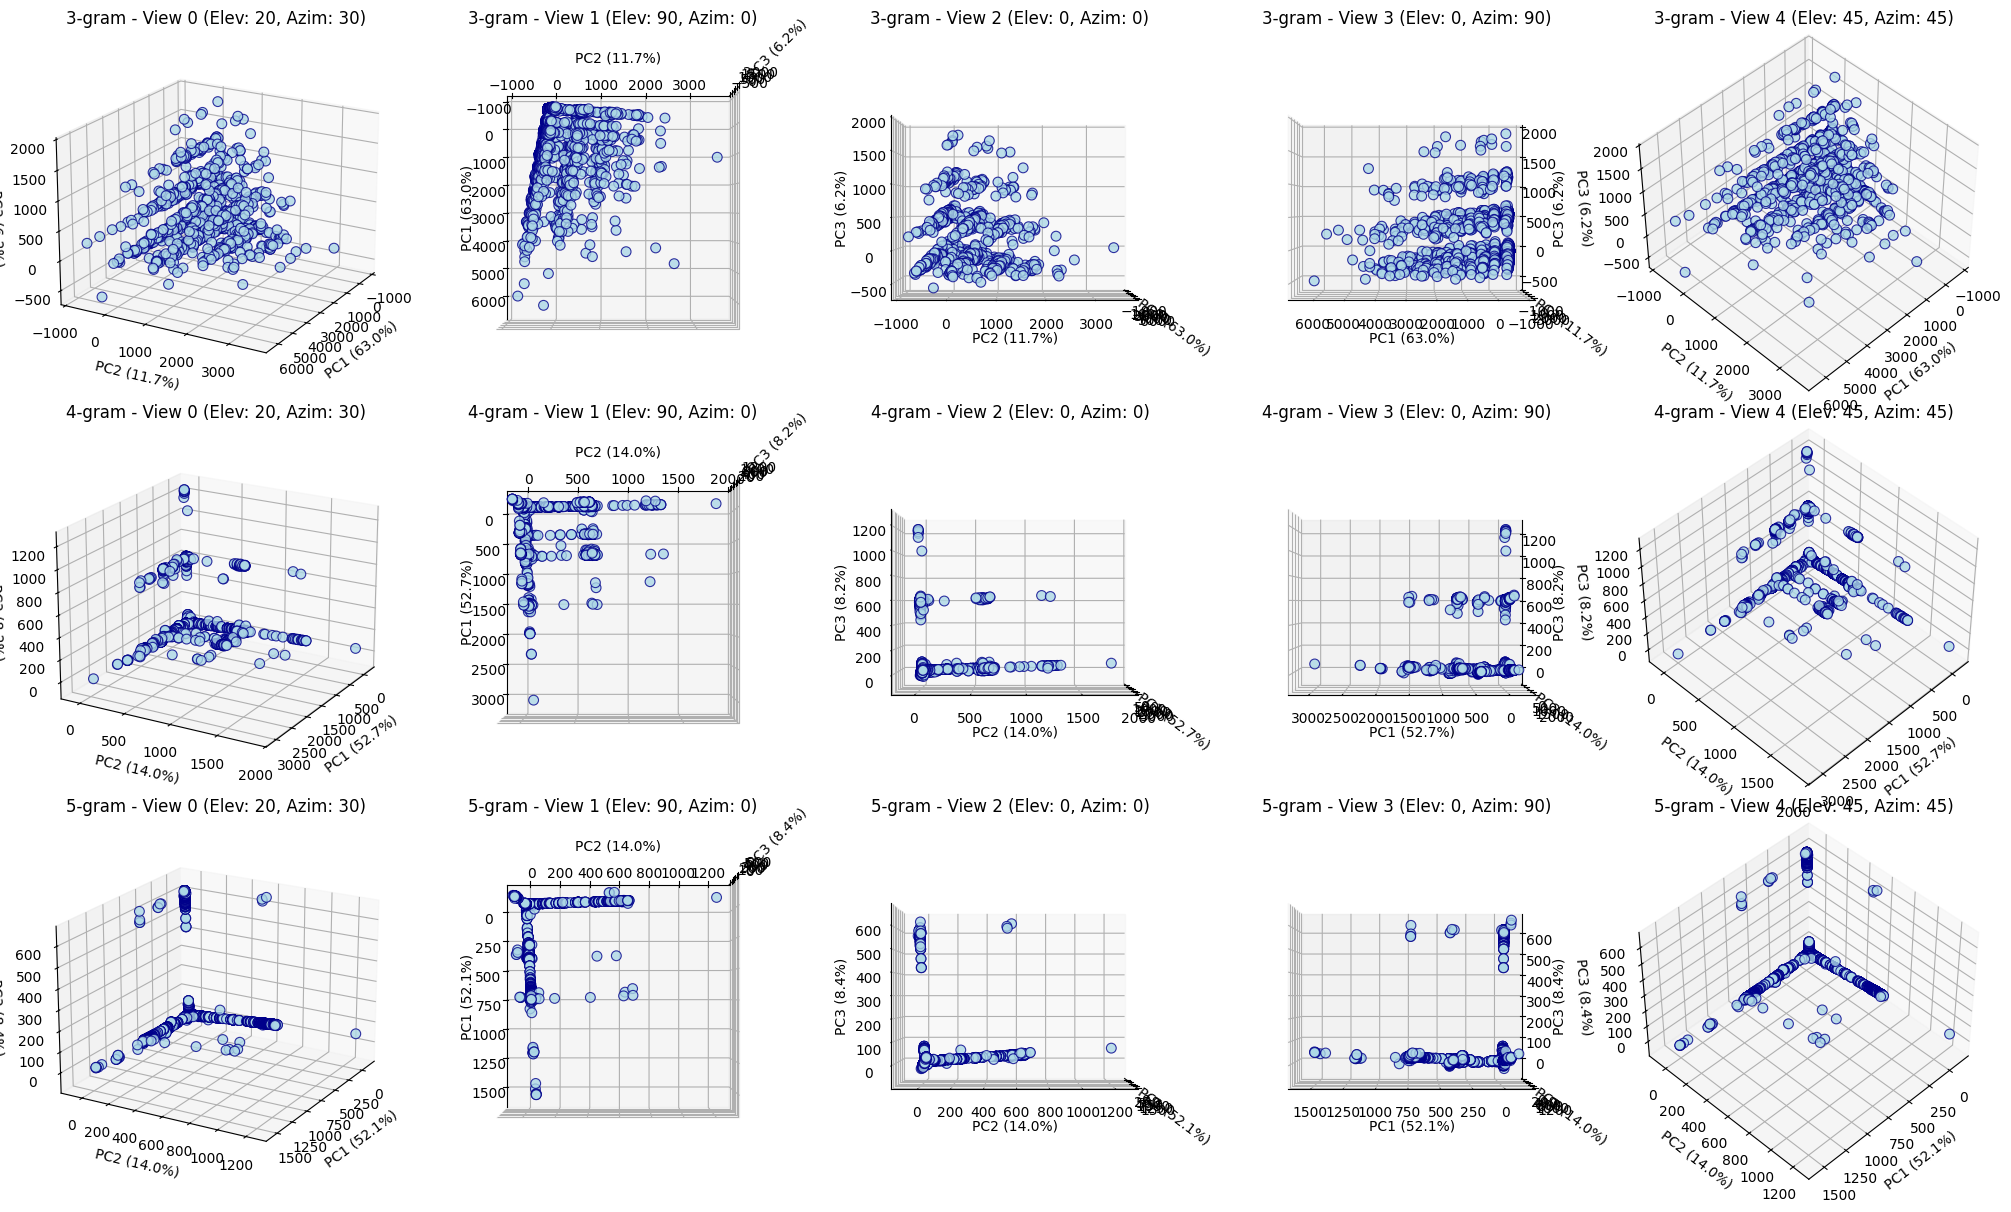

In [15]:
_3d_views(datasets)

#  Hierarchical Clustering

In [4]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram

In [5]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def hierarchical_clustering(datasets):
    """
    Hierarchical (agglomerative) clustering evaluation PO N-GRAMIMA.
    Očekuje: redovi = n-grami; kolone = virus.protein (numeričke) + pomoćne ('dominant_*').
    Računa silhouette, calinski, davies za različite brojeve klastera.
    """
    cluster_range = range(2, 11)
    results = {name: {"clusters": [], "silhouette": [], "calinski": [], "davies": []}
               for name in datasets}

    for name, df in datasets.items():
        # uzmi SAMO numeričke kolone (frekvencije po virus.protein kolonama)
        X = df.select_dtypes(include=['number']).values
        # standardizuj zbog metrika/udaljenosti
        Xs = StandardScaler().fit_transform(X)

        for k in cluster_range:
            model = AgglomerativeClustering(n_clusters=k, linkage="ward")
            labels = model.fit_predict(Xs)

            results[name]["clusters"].append(k)
            results[name]["silhouette"].append(silhouette_score(Xs, labels))
            results[name]["calinski"].append(calinski_harabasz_score(Xs, labels))
            results[name]["davies"].append(davies_bouldin_score(Xs, labels))

    # Plot metric scores for each dataset
    fig, axes = plt.subplots(len(datasets), 3, figsize=(18, 4 * len(datasets)))
    if len(datasets) == 1:
        axes = [axes]

    metrics = ["silhouette", "calinski", "davies"]
    for i, (name, scores) in enumerate(results.items()):
        for j, metric in enumerate(metrics):
            ax = axes[i][j] if len(datasets) > 1 else axes[j]
            ax.plot(scores["clusters"], scores[metric], marker='o')
            ax.set_title(f"{name} - {metric}")
            ax.set_xlabel("Broj klastera")
            ax.set_ylabel(metric.capitalize())

    plt.tight_layout()
    plt.show()
    return results

In [6]:
df3 = load_csv("../csv_data/3gram_matrix_amino_acid_combined.csv")
df4 = load_csv("../csv_data/4gram_matrix_amino_acid_combined.csv")
df5 = load_csv("../csv_data/5gram_matrix_amino_acid_combined.csv")
datasets = {"3-gram": df3, "4-gram": df4, "5-gram": df5}

In [ ]:
hierarchical_clustering(datasets)

In [ ]:
def get_color_map_for_labels(datasets, label_key="dominant_virus"):
    """
    Generiše mapu labela u boje na osnovu label_key:
      - 'dominant_virus' ili 'dominant_protein'
    """
    all_labels = pd.concat([
        df[label_key].astype(str).dropna()
        for df in datasets.values() if label_key in df.columns
    ])
    unique_labels = sorted(all_labels.unique())
    num_labels = max(len(unique_labels), 1)

    cmap = plt.get_cmap("tab20")
    color_map = {label: cmap(i / num_labels) for i, label in enumerate(unique_labels)}
    return color_map

In [ ]:
from sklearn.decomposition import PCA

def visualize_clusters_only(datasets, label_key="dominant_virus", k=2):
    """
    Vizuelizuje hijerarhijske klastere (Agglomerative) u 2D (PCA),
    boji tačke po 'dominant_virus' ili 'dominant_protein'.
    """
    color_map = get_color_map_for_labels(datasets, label_key)

    n_plots = len(datasets)
    fig, axs = plt.subplots(1, n_plots, figsize=(18, 5))
    if n_plots == 1:
        axs = [axs]

    for ax, (name, df) in zip(axs, datasets.items()):
        # labele za bojenje po REDOVIMA (n-gramima)
        if label_key in df.columns:
            labels_series = df[label_key].astype(str)
        else:
            labels_series = pd.Series(["all"] * len(df), index=df.index)

        # numeričke kolone su feature-i (virus.protein frekvencije)
        X = df.select_dtypes(include=[np.number]).values

        # PCA smanjenje dimenzije
        pca = PCA(n_components=2, random_state=42)
        reduced = pca.fit_transform(X)

        # Hijerarhijsko klasterovanje
        model = AgglomerativeClustering(n_clusters=k, linkage="ward")
        clusters = model.fit_predict(X)

        # "centroidi" klastera u PCA prostoru (sredina tačaka klastera)
        centers = []
        for cid in range(k):
            pts = reduced[clusters == cid]
            centers.append(pts.mean(axis=0) if len(pts) else np.array([np.nan, np.nan]))
        centers_2d = np.vstack(centers)

        # boje po labelama
        colors = labels_series.map(color_map)

        # scatter tačaka
        ax.scatter(reduced[:, 0], reduced[:, 1], c=colors, s=80, edgecolor='k')

        # "centroidi" kao X
        ax.scatter(centers_2d[:, 0], centers_2d[:, 1],
                   marker='x', c='black', s=150, linewidths=3, label='Cluster centroid')

        ax.set_title(f"{name} – klasteri i '{label_key}'", fontsize=14)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_aspect('equal')

        handles = [mpatches.Patch(color=color_map[lbl], label=lbl)
                   for lbl in sorted(labels_series.unique())]
        ax.legend(handles=handles, title=label_key,
                  bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

In [ ]:
def draw_legend_for_labels(datasets, label_key="dominant_virus"):
    """
    Iscrtava legendu za sve jedinstvene labele iz datasets (dominant_virus ili dominant_protein),
    koristeći boje iz get_color_map_for_labels.
    """
    color_map = get_color_map_for_labels(datasets, label_key)
    unique_labels = sorted(color_map.keys())
    colors = [color_map[lbl] for lbl in unique_labels]

    ncol = 4
    n_rows = int(np.ceil(len(unique_labels) / ncol))
    fig_height = 0.6 + n_rows * 0.3

    fig, ax = plt.subplots(figsize=(12, fig_height))
    ax.axis("off")

    handles = [mpatches.Patch(color=colors[i], label=unique_labels[i])
               for i in range(len(unique_labels))]

    ax.legend(handles=handles, title=label_key,
              loc="upper center", bbox_to_anchor=(0.5, 1.0),
              fontsize=10, ncol=ncol, frameon=False)

    plt.subplots_adjust(top=1, bottom=0, left=0.05, right=0.95)
    plt.show()

In [ ]:
visualize_clusters_only(datasets, label_key="virus_type", k=3)

In [ ]:
draw_legend_for_labels(datasets, label_key="virus_type")

In [ ]:
visualize_clusters_only(datasets, label_key="protein_type", k=3)

In [ ]:
draw_legend_for_labels(datasets, label_key="protein_type")

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

def plot_dendrograms_simplified(datasets):
    """
    Nacrta skraćene dendrograme PO N-GRAMIMA.
    Uzimaju se samo numeričke kolone (frekvencije).
    """
    n_plots = len(datasets)
    fig, axs = plt.subplots(n_plots, 1, figsize=(20, 5 * n_plots))
    if n_plots == 1:
        axs = [axs]

    for ax, (name, df) in zip(axs, datasets.items()):
        X = df.select_dtypes(include=['number']).values
        Z = linkage(X, method='ward')

        dendrogram(
            Z, ax=ax,
            truncate_mode='level', p=6,
            labels=None,
            leaf_rotation=90, leaf_font_size=6,
            show_contracted=True, show_leaf_counts=True,
            distance_sort='descending'
        )
        ax.set_title(f"Simplified Dendrogram - {name}", fontsize=14)
        ax.set

In [ ]:
plot_dendrograms_simplified(datasets)

# SOM

In [ ]:
from minisom import MiniSom
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
from minisom import MiniSom
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA  # (nije obavezno ovde, ali često korisno)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def som(datasets, label_column='virus_type', som_x=15, som_y=15, iterations=1000):
    """
    Treniranje i vizuelizacija SOM-a PO N-GRAMIMA (redovi = n-grami).
    - `datasets` može biti dict {ime: df} ili jedan df.
    - `label_column` se koristi samo za bojenje tačaka:
         'dominant_virus' ili 'dominant_protein'

    Vraća listu results sa ključevima:
      - 'n_gram'                  : ime dataseta
      - 'n_units_hit'             : koliko SOM jedinica je dobijeno sa barem jednim pogodkom (aktivne BMU)
      - 'bmu_coords'              : (n_samples x 2) koordinate BMU-a po uzorku (n-gramu)
      - 'assign_df'               : DataFrame sa ngram, bmu_x, bmu_y, unit_id, dominant_virus, dominant_protein
      - 'per_unit_counts_by_virus': tabela (#BMU jedinica x virusi) – broj n-gramova po virusu u jedinici
      - 'per_unit_counts_by_protein': (#BMU jedinica x proteini) – broj n-gramova po proteinu u jedinici
    """
    if isinstance(datasets, dict):
        items = list(datasets.items())
    else:
        items = [("dataset", datasets)]

    results = []

    # Figure za U-matricu i pozicije
    fig, axes = plt.subplots(len(items), 2, figsize=(12, 5 * len(items)))
    if len(items) == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, (ngram_name, df) in enumerate(items):
        # --- odabir label kolone za bojenje (fallback logika) ---
        label_key = label_column
        if label_key not in df.columns:
            if "dominant_virus" in df.columns:
                label_key = "dominant_virus"
            elif "dominant_protein" in df.columns:
                label_key = "dominant_protein"
            else:
                # ako zaista nema ničega, napravi neutralne labele
                df = df.copy()
                df["__all__"] = "all"
                label_key = "__all__"

        labels = df[label_key].astype(str).values

        # --- vektori karakteristika: SAMO numeričke kolone (virus.protein frekvencije) ---
        features_df = df.select_dtypes(include=[np.number])
        X = features_df.values

        # --- skaliranje ---
        scaler = StandardScaler()
        Xs = scaler.fit_transform(X)

        # --- treniranje SOM-a ---
        som_obj = MiniSom(x=som_x, y=som_y, input_len=Xs.shape[1], sigma=1.0, learning_rate=0.5)
        som_obj.random_weights_init(Xs)
        som_obj.train_random(Xs, num_iteration=iterations)

        # --- BMU koordinate po uzorku (n-gramu) ---
        bmu_coords = np.array([som_obj.winner(x) for x in Xs])
        unit_ids = bmu_coords[:, 0] * som_y + bmu_coords[:, 1]

        # --- pripremi boje (diskretne) po labelama ---
        unique_labels = sorted(pd.unique(labels))
        label_to_int = {lab: idx for idx, lab in enumerate(unique_labels)}
        color_labels = np.array([label_to_int[lab] for lab in labels])

        # --- rezultati za interpretaciju ---
        # DataFrame dodela po n-gramu
        assign_df = pd.DataFrame({
            "ngram": df.index.astype(str),
            "bmu_x": bmu_coords[:, 0],
            "bmu_y": bmu_coords[:, 1],
            "unit_id": unit_ids,
            "dominant_virus": df["dominant_virus"] if "dominant_virus" in df.columns else "NA",
            "dominant_protein": df["dominant_protein"] if "dominant_protein" in df.columns else "NA"
        })

        # Po jedinici: broj n-gramova po VIRUSU
        if "dominant_virus" in assign_df.columns:
            per_unit_counts_by_virus = (assign_df
                                        .groupby(["unit_id", "dominant_virus"])
                                        .size()
                                        .unstack(fill_value=0)
                                        .sort_index())
        else:
            per_unit_counts_by_virus = pd.DataFrame()

        # Po jedinici: broj n-gramova po PROTEINU
        if "dominant_protein" in assign_df.columns:
            per_unit_counts_by_protein = (assign_df
                                          .groupby(["unit_id", "dominant_protein"])
                                          .size()
                                          .unstack(fill_value=0)
                                          .sort_index())
        else:
            per_unit_counts_by_protein = pd.DataFrame()

        # --- koliko SOM jedinica je “aktivno” (ima barem jedan pogodak) ---
        n_units_hit = assign_df["unit_id"].nunique()

        results.append({
            "n_gram": ngram_name,
            "n_units_hit": int(n_units_hit),
            "bmu_coords": bmu_coords,
            "assign_df": assign_df,
            "per_unit_counts_by_virus": per_unit_counts_by_virus,
            "per_unit_counts_by_protein": per_unit_counts_by_protein
        })

        # Vizuelizacije

        # 1) U-Matrix
        ax1 = axes[i, 0]
        ax1.set_title(f"SOM U-Matrix ({ngram_name})")
        um = som_obj.distance_map().T
        im = ax1.pcolor(um, cmap='bone_r')
        fig.colorbar(im, ax=ax1)
        ax1.set_xlim(0, som_x)
        ax1.set_ylim(0, som_y)

        # 2) Pozicije BMU obojene po labelama (virus/protein)
        ax2 = axes[i, 1]
        ax2.set_title(f"SOM colored by {label_key} ({ngram_name})")
        scatter = ax2.scatter(bmu_coords[:, 0], bmu_coords[:, 1],
                              c=color_labels, cmap='tab20', s=40, edgecolors='k')
        ax2.set_xlim(0, som_x)
        ax2.set_ylim(0, som_y)

        # Legenda
        ax2.legend(handles=scatter.legend_elements()[0],
                   labels=unique_labels, title=label_key, bbox_to_anchor=(1.05, 1),
                   loc='upper left')

    plt.tight_layout()
    plt.show()
    return results


In [ ]:
df3 = load_csv("../csv_data/3gram_matrix_amino_acid_combined.csv")
df4 = load_csv("../csv_data/4gram_matrix_amino_acid_combined.csv")
df5 = load_csv("../csv_data/5gram_matrix_amino_acid_combined.csv")
datasets = {"3-gram": df3, "4-gram": df4, "5-gram": df5}

In [ ]:
som_res_v = som(datasets, label_column="dominant_virus", som_x=15, som_y=15, iterations=1000)

In [ ]:
som_res_p = som(datasets, label_column="dominant_protein", som_x=15, som_y=15, iterations=1000)